In [1]:
import os

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
os.chdir('../..')
os.getcwd()

'/home/max/mcrc-cetuximab-analysis'

In [2]:
log_tpms = pd.read_csv('data/log_tpms_from_fpkm_hgnc_no_metastases_maxim.csv').drop(columns=['Unnamed: 0'])
ann = pd.read_csv('data/useful_ann_no_metastases_maxim.csv').drop(columns=['Unnamed: 0'])

def is_post(row):
    return str(row['time point']) != 'nan' and row['time point'].find('post-treatment') != -1 

def is_pre(row):
    return str(row['time point']) != 'nan' and row['time point'].find('pre-treatment') != -1 


ann_post = ann.loc[ann.apply(is_post, axis=1),:]
ann_pre = ann.loc[ann.apply(is_pre, axis=1),:]

log_tpms_post = log_tpms.merge(ann_post, on='sample_id', how='inner')[log_tpms.columns]
log_tpms_pre = log_tpms.merge(ann_pre, on='sample_id', how='inner')[log_tpms.columns]
print(len(log_tpms_post), len(log_tpms_pre))

13 67


In [3]:
def plot_correlations(df, title, target_gene, gene_list_file, ax, xlim=(-0.5, 0.5), alpha=0.01):
    genes = open(gene_list_file, 'r').read().strip().split(', ')
    print(f'{target_gene} genes in total: ', len(genes))
    genes = list(filter(lambda gene: gene in df.columns, genes))
    print(f'{target_gene} genes in our data: ', len(genes))
    corrs = np.array([stats.pearsonr(df[target_gene], df[gene])[0] for gene in genes])
    ps = np.array([stats.pearsonr(df[target_gene], df[gene])[1] for gene in genes])
    neg_log_ps = np.array([-np.log10(p) for p in ps])
    neg_log_ps = np.nan_to_num(neg_log_ps, posinf=10)
    neg_log_ps = np.minimum(neg_log_ps, 10)
    
    neg_corrs = (corrs < 0) & (ps < alpha)
    pos_corrs = (corrs > 0) & (ps < alpha)
    neg_genes = [genes[i] for i in range(len(genes)) if neg_corrs[i]]
    pos_genes = [genes[i] for i in range(len(genes)) if pos_corrs[i]]
    print('Negative genes: ', ', '.join(neg_genes))
    print('Positive genes: ', ', '.join(pos_genes))
       
    plt.figure(figsize=(16,9))
    
    
    sns.scatterplot(x=corrs, y=neg_log_ps, ax=ax)
    for i, gene in enumerate(genes):
        ax.text(corrs[i]+0.01, neg_log_ps[i]+0.01, gene, fontsize=12)
    
    ax.plot([xlim[0], xlim[1]], [-np.log10(alpha), -np.log10(alpha)], label='p=0.01')
    ax.legend()
    
    ax.set_xticks(np.linspace(xlim[0], xlim[1], 21))
    
    ax.set_title(title)
    ax.set_xlabel('Pearson correlation')
    ax.set_ylabel('-log10 P-value')

MET genes in total:  48
MET genes in our data:  45
Negative genes:  MAPK10, MAP3K3, MKNK1
Positive genes:  
MET genes in total:  48
MET genes in our data:  45
Negative genes:  MAPK10, MAPK11, MAPK12
Positive genes:  NRAS


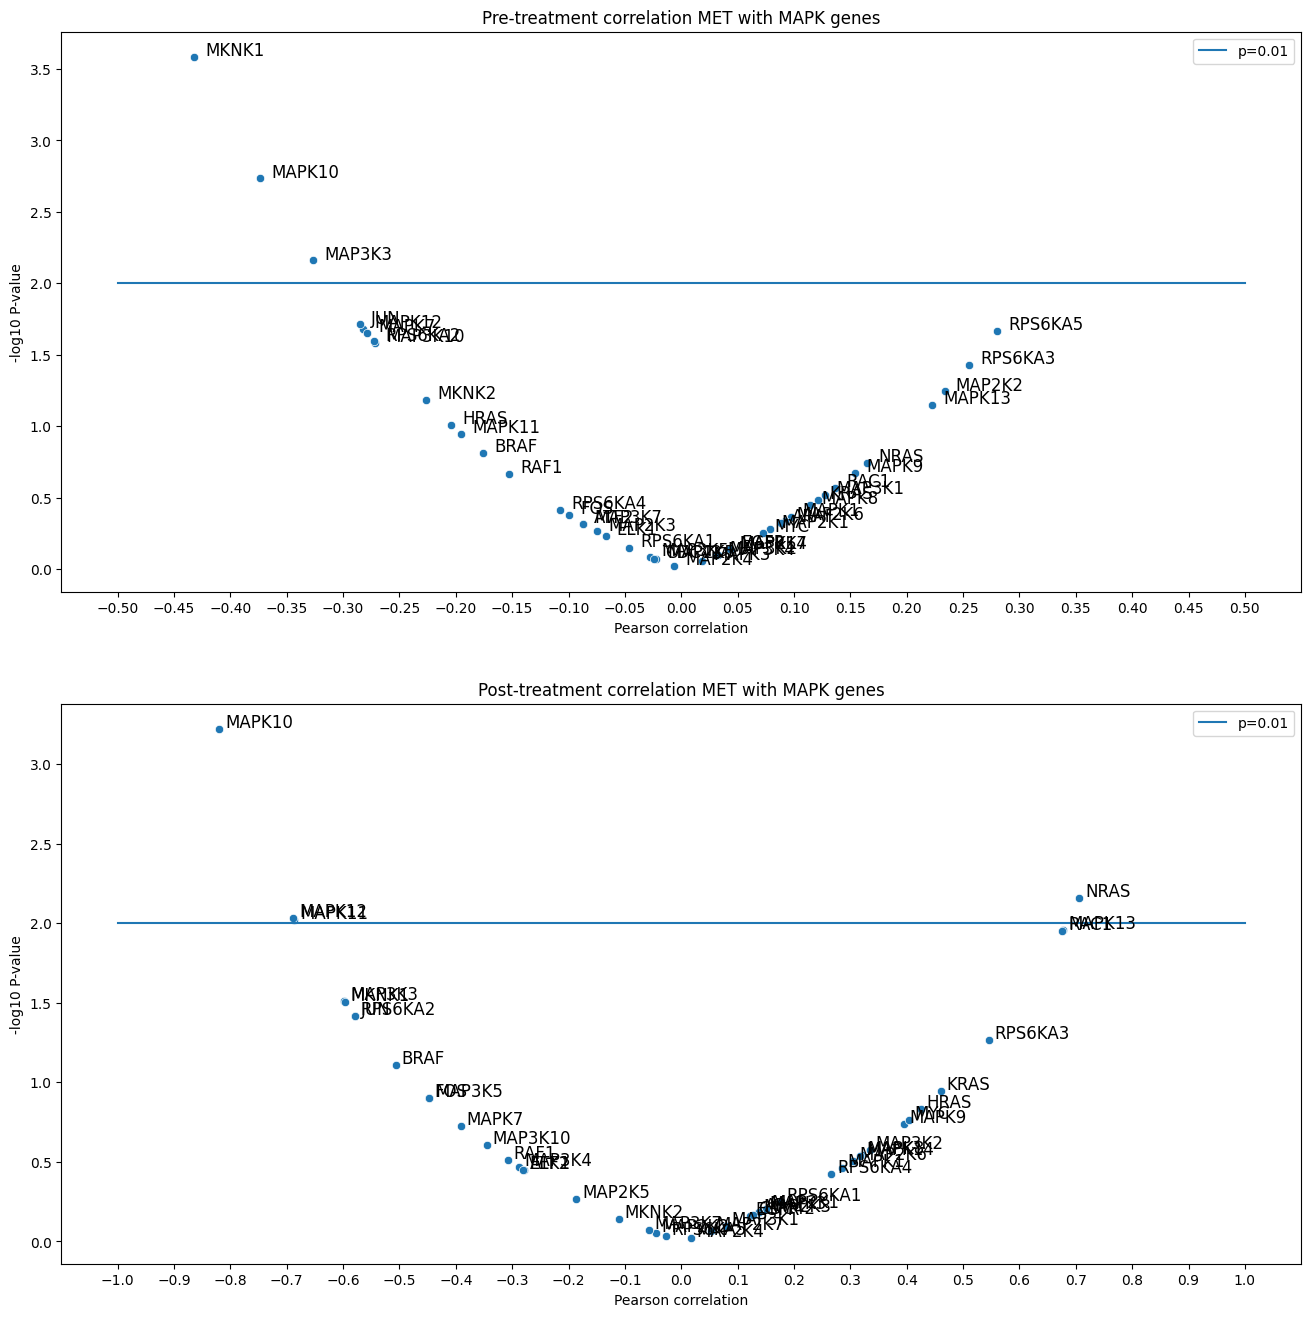

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

plot_correlations(log_tpms_pre, 'Pre-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/mapk_genes.txt',
                  xlim=(-0.5, 0.5), ax=axs[0])
plot_correlations(log_tpms_post, 'Post-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/mapk_genes.txt',
                  xlim=(-1, 1), ax=axs[1])

MET genes in total:  86
MET genes in our data:  81
Negative genes:  PIK3CD, RELA, BCL2, CASP9, VEGFB, ANGPT1, TEK, JAK1
Positive genes:  RHEB, CHUK, E2F3, MET
MET genes in total:  86
MET genes in our data:  81
Negative genes:  PIK3CD, PIK3CG, TSC1, IRS1, ANGPT1, TEK, IL6ST, JAK1, STAT5B
Positive genes:  RHEB, NRAS, TGFA, MET


/tmp/ipykernel_26686/2129659555.py:8: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])
/tmp/ipykernel_26686/2129659555.py:8: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])


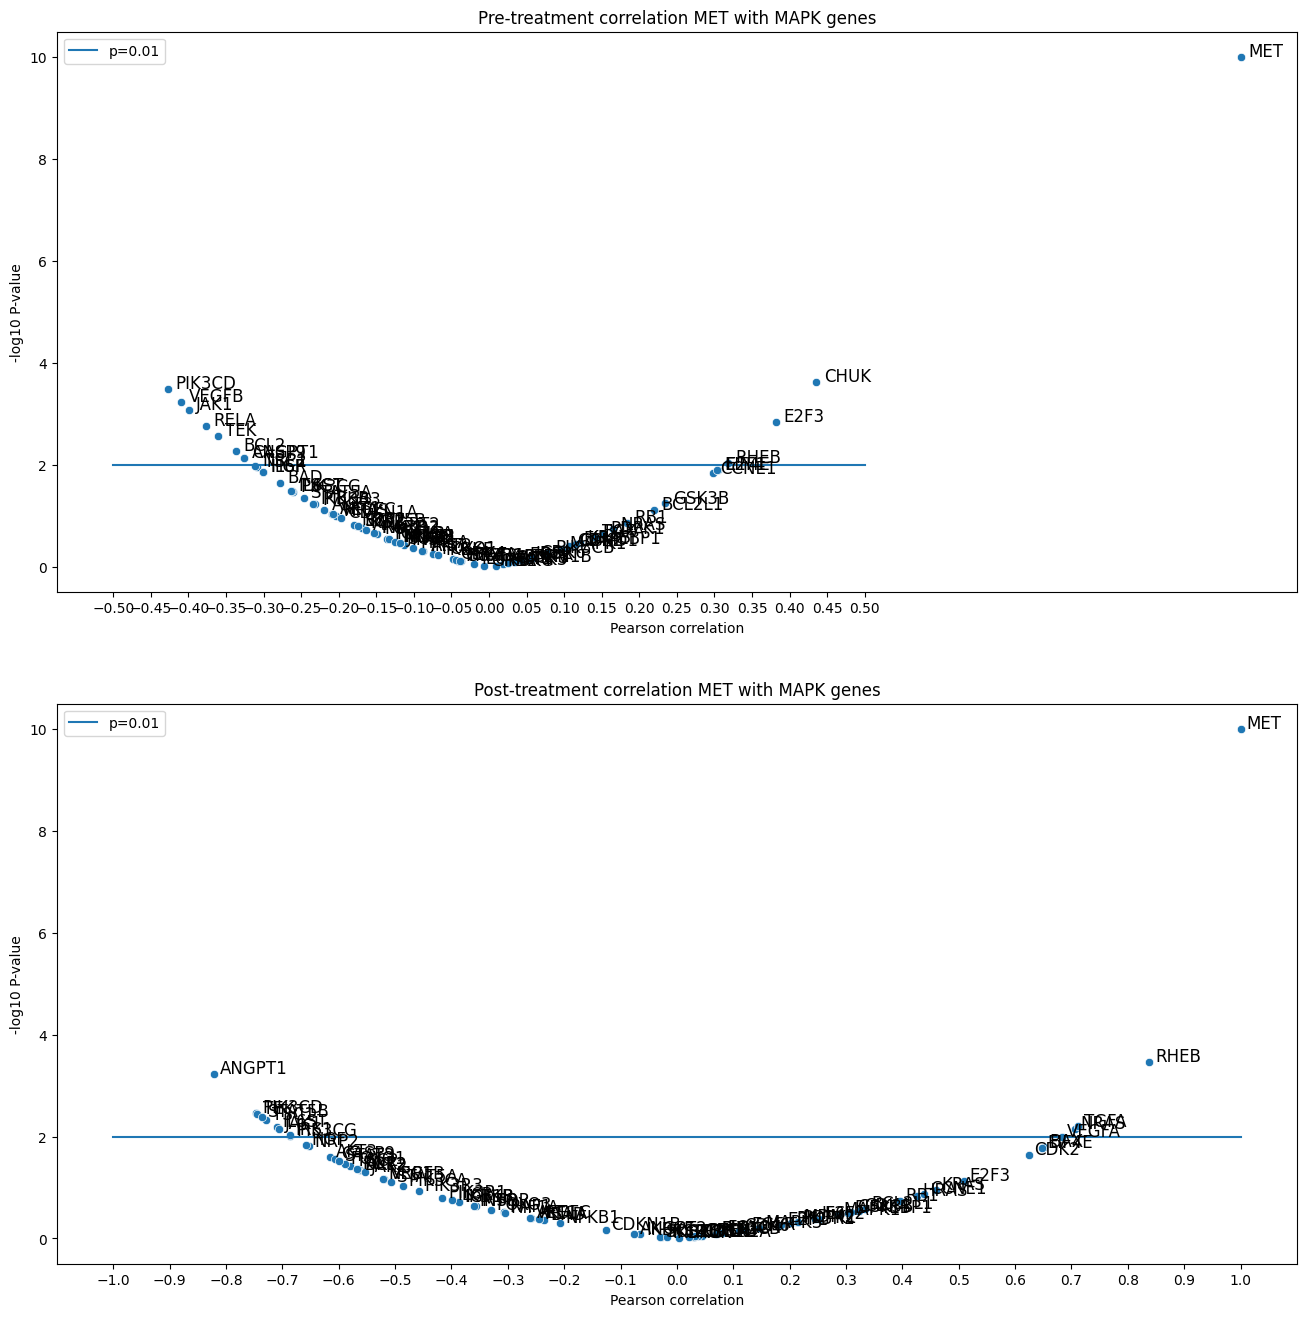

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

plot_correlations(log_tpms_pre, 'Pre-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/pi3k_genes.txt',
                  xlim=(-0.5, 0.5), ax=axs[0])
plot_correlations(log_tpms_post, 'Post-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/pi3k_genes.txt',
                  xlim=(-1, 1), ax=axs[1])

In [6]:
our_genes = log_tpms.columns 

def parse_emt(file):
    res = []
    full_res = []
    for line in open(file, 'r').readlines():
        if not line.startswith('(') and not line.startswith('GO') and not line.startswith('Gene'):
            full_res.append(line.split()[0])
        if not line.startswith('(') and not line.startswith('GO') and not line.startswith('Gene') and line.split()[0] in our_genes:
            res.append(line.split()[0])
    return full_res, res

emt_files = ['raw/' + file for file in os.listdir('raw') if file.startswith('emt')]
emt_gene_lists = {file[file.find('/') + 1:file.find('.')]: parse_emt(file)[1] for file in emt_files}
emt_full_gene_lists = {file[file.find('/') + 1:file.find('.')]: parse_emt(file)[0] for file in emt_files}

for filename, lst in emt_gene_lists.items():
    open(f'data/gene_lists/{filename}.txt', 'w').write(', '.join(lst))
    print('Full emt signatures / filtered to our genes', len(emt_full_gene_lists[filename]), len(emt_gene_lists[filename]))

Full emt signatures / filtered to our genes 9 9
Full emt signatures / filtered to our genes 33 33
Full emt signatures / filtered to our genes 82 81
Full emt signatures / filtered to our genes 5 5
Full emt signatures / filtered to our genes 20 18


MET genes in total:  9
MET genes in our data:  9
Negative genes:  ANK2, VIM
Positive genes:  CDH17
MET genes in total:  9
MET genes in our data:  9
Negative genes:  ANK2, ZEB1
Positive genes:  CDH17, RAB25
MET genes in total:  33
MET genes in our data:  33
Negative genes:  CDH11, DDR2, FZD7, IGF1, IGFBP5, PRICKLE1, SFRP1, SFRP2, SFRP4, SPARC, THBS1, VIM, ZEB2
Positive genes:  
MET genes in total:  33
MET genes in our data:  33
Negative genes:  FZD1, IGFBP5, NXN, SFRP1, ZEB1, ZEB2
Positive genes:  
MET genes in total:  81
MET genes in our data:  81
Negative genes:  ACTN1, CCND2, CDH11, COL6A3, ENG, GLI3, IGFBP3, IGFBP4, LEF1, NFATC1, PIK3CD, PTN, SPARC, VIM
Positive genes:  OCLN
MET genes in total:  81
MET genes in our data:  81
Negative genes:  ADGRL2, CAVIN3, COL6A3, IGFBP4, MMP2, NFATC1, PIK3CD, PTN, ZEB1
Positive genes:  ERBB3, OCLN, VIL1
MET genes in total:  5
MET genes in our data:  5
Negative genes:  VIM
Positive genes:  
MET genes in total:  5
MET genes in our data:  5
Negative 

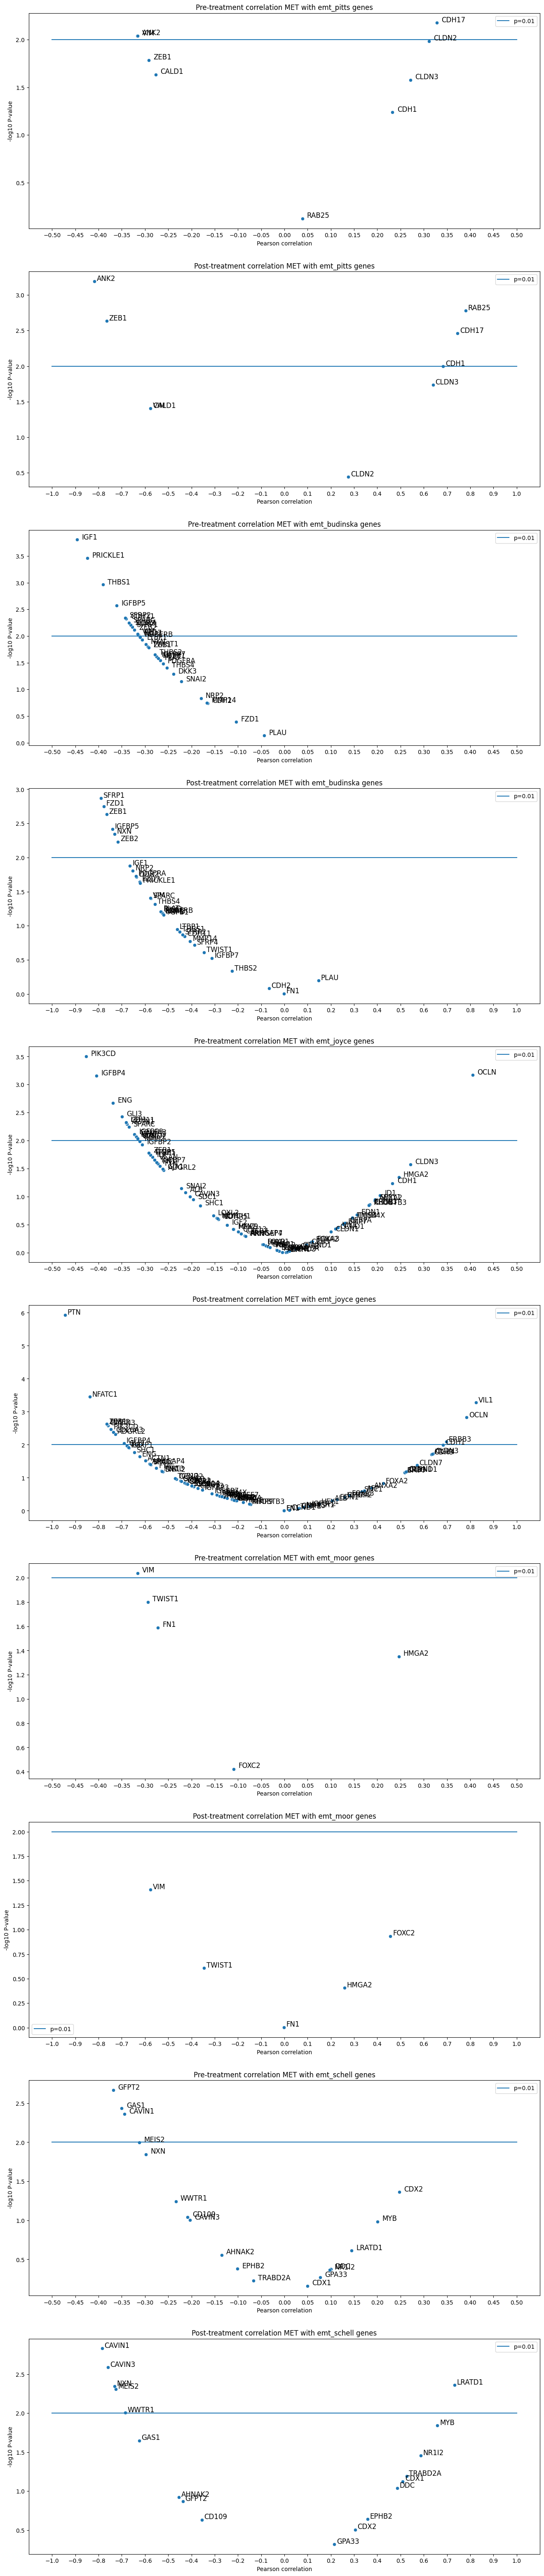

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [7]:
fig, axs = plt.subplots(2 * len(emt_gene_lists), 1, figsize=(16, 16 * len(emt_gene_lists)))


for i, filename in enumerate(emt_gene_lists):
    plot_correlations(log_tpms_pre, f'Pre-treatment correlation MET with {filename} genes',
                      'MET', f'data/gene_lists/{filename}.txt',
                      xlim=(-0.5, 0.5), ax=axs[i * 2])
    plot_correlations(log_tpms_post, f'Post-treatment correlation MET with {filename} genes', 
                      'MET', f'data/gene_lists/{filename}.txt',
                      xlim=(-1, 1), ax=axs[i * 2 + 1])

In [8]:
import gseapy as gp

print({key: len(emt_gene_lists[key]) for key in emt_gene_lists})

ssgsea_results = gp.ssgsea(data=log_tpms.set_index('sample_id').T,
                           gene_sets=emt_gene_lists,
                           outdir=None,
                           sample_norm_method='rank',
                           permutation_num=0,
                           no_plot=True,
                           min_size=0)

ssgsea_df = ssgsea_results.res2d.rename(columns={'Name': 'sample_id'})
ssgsea_df

{'emt_pitts': 9, 'emt_budinska': 33, 'emt_joyce': 81, 'emt_moor': 5, 'emt_schell': 18}


,sample_id,Term,ES,NES
0,18R695_0003,emt_budinska,7685.590367,1.144804
1,18R678_0010,emt_pitts,7394.928118,1.101509
2,18R648_0009,emt_pitts,7303.422808,1.087879
3,18R470_0011,emt_pitts,7292.651754,1.086274
4,18R435_0015,emt_pitts,7210.182966,1.07399
...,...,...,...,...
400,18R437_0018,emt_budinska,1657.941999,0.246958
401,18R508_0011,emt_schell,1540.260766,0.229429
402,18R461_0002,emt_schell,1382.399376,0.205915
403,18R465_0006,emt_schell,1008.256055,0.150184


In [9]:
log_tpms_with_emt_signatures = log_tpms.copy()
for signature in emt_gene_lists:
    add = ssgsea_df.loc[ssgsea_df['Term'] == signature, ['sample_id', 'ES']]
    log_tpms_with_emt_signatures = log_tpms_with_emt_signatures.merge(add, on='sample_id').rename(columns={'ES': signature})

print(log_tpms_with_emt_signatures.isna().sum().max())
log_tpms_with_emt_signatures

0


,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,FAM90A8,LCE7A,FAM90A10,FAM90A7,sample_id,emt_pitts,emt_budinska,emt_joyce,emt_moor,emt_schell
0,5.672374,0.000000,7.893859,3.436497,4.016985,1.061024,5.464971,5.005462,6.616661,4.511973,...,0.0,0.0,0.0,0.0,18R177_0021,5866.953843,2384.899609,4012.613275,3077.784986,2498.450689
1,5.674291,0.360345,8.864981,3.459952,5.127833,1.333578,5.479336,5.518125,6.684637,4.339141,...,0.0,0.0,0.0,0.0,18R178_0022,6594.988994,3535.281233,4441.565678,4514.80957,2508.789633
2,7.606478,0.502548,8.949938,2.945925,3.997846,2.127446,5.718449,5.033901,6.493254,4.272012,...,0.0,0.0,0.0,0.0,18R296_0008,6688.133068,2560.345451,4066.70393,2408.561145,2107.552986
3,6.804048,2.781194,8.366144,2.738390,4.675337,1.072083,5.625562,5.008174,6.897100,3.967913,...,0.0,0.0,0.0,0.0,18R301_0002,6963.490954,4101.9309,4683.048238,4587.941901,2643.881037
4,5.108591,1.154345,7.674760,3.302905,4.219908,2.369596,6.224519,5.742430,6.676583,4.355505,...,0.0,0.0,0.0,0.0,18R421_0001,6961.328867,5110.859381,4722.042227,4102.089534,3114.868401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,5.826797,0.245345,8.543566,3.406724,4.605106,1.638539,5.373508,5.002043,6.725416,3.989550,...,0.0,0.0,0.0,0.0,18R299_0025,6698.388759,2986.995389,4070.420327,1983.059407,2505.74306
77,6.010276,1.360005,9.144012,2.642160,4.045131,1.411634,5.899354,4.646930,6.749096,5.013906,...,0.0,0.0,0.0,0.0,18R300_0027,6362.429895,3682.437658,4407.384924,4139.060665,2405.685538
78,7.224287,0.493080,9.016678,2.605669,4.270374,2.048614,6.498189,5.551379,6.817707,4.143490,...,0.0,0.0,0.0,0.0,18R302_0004,6227.700952,4564.051229,4212.086967,3978.257456,2415.726374
79,4.231267,0.000000,8.674503,3.044790,5.025915,1.606929,5.103568,5.394718,8.059738,4.181427,...,0.0,0.0,0.0,0.0,18R307_0013,6654.420387,4070.798865,4320.105607,3857.706142,2410.398376


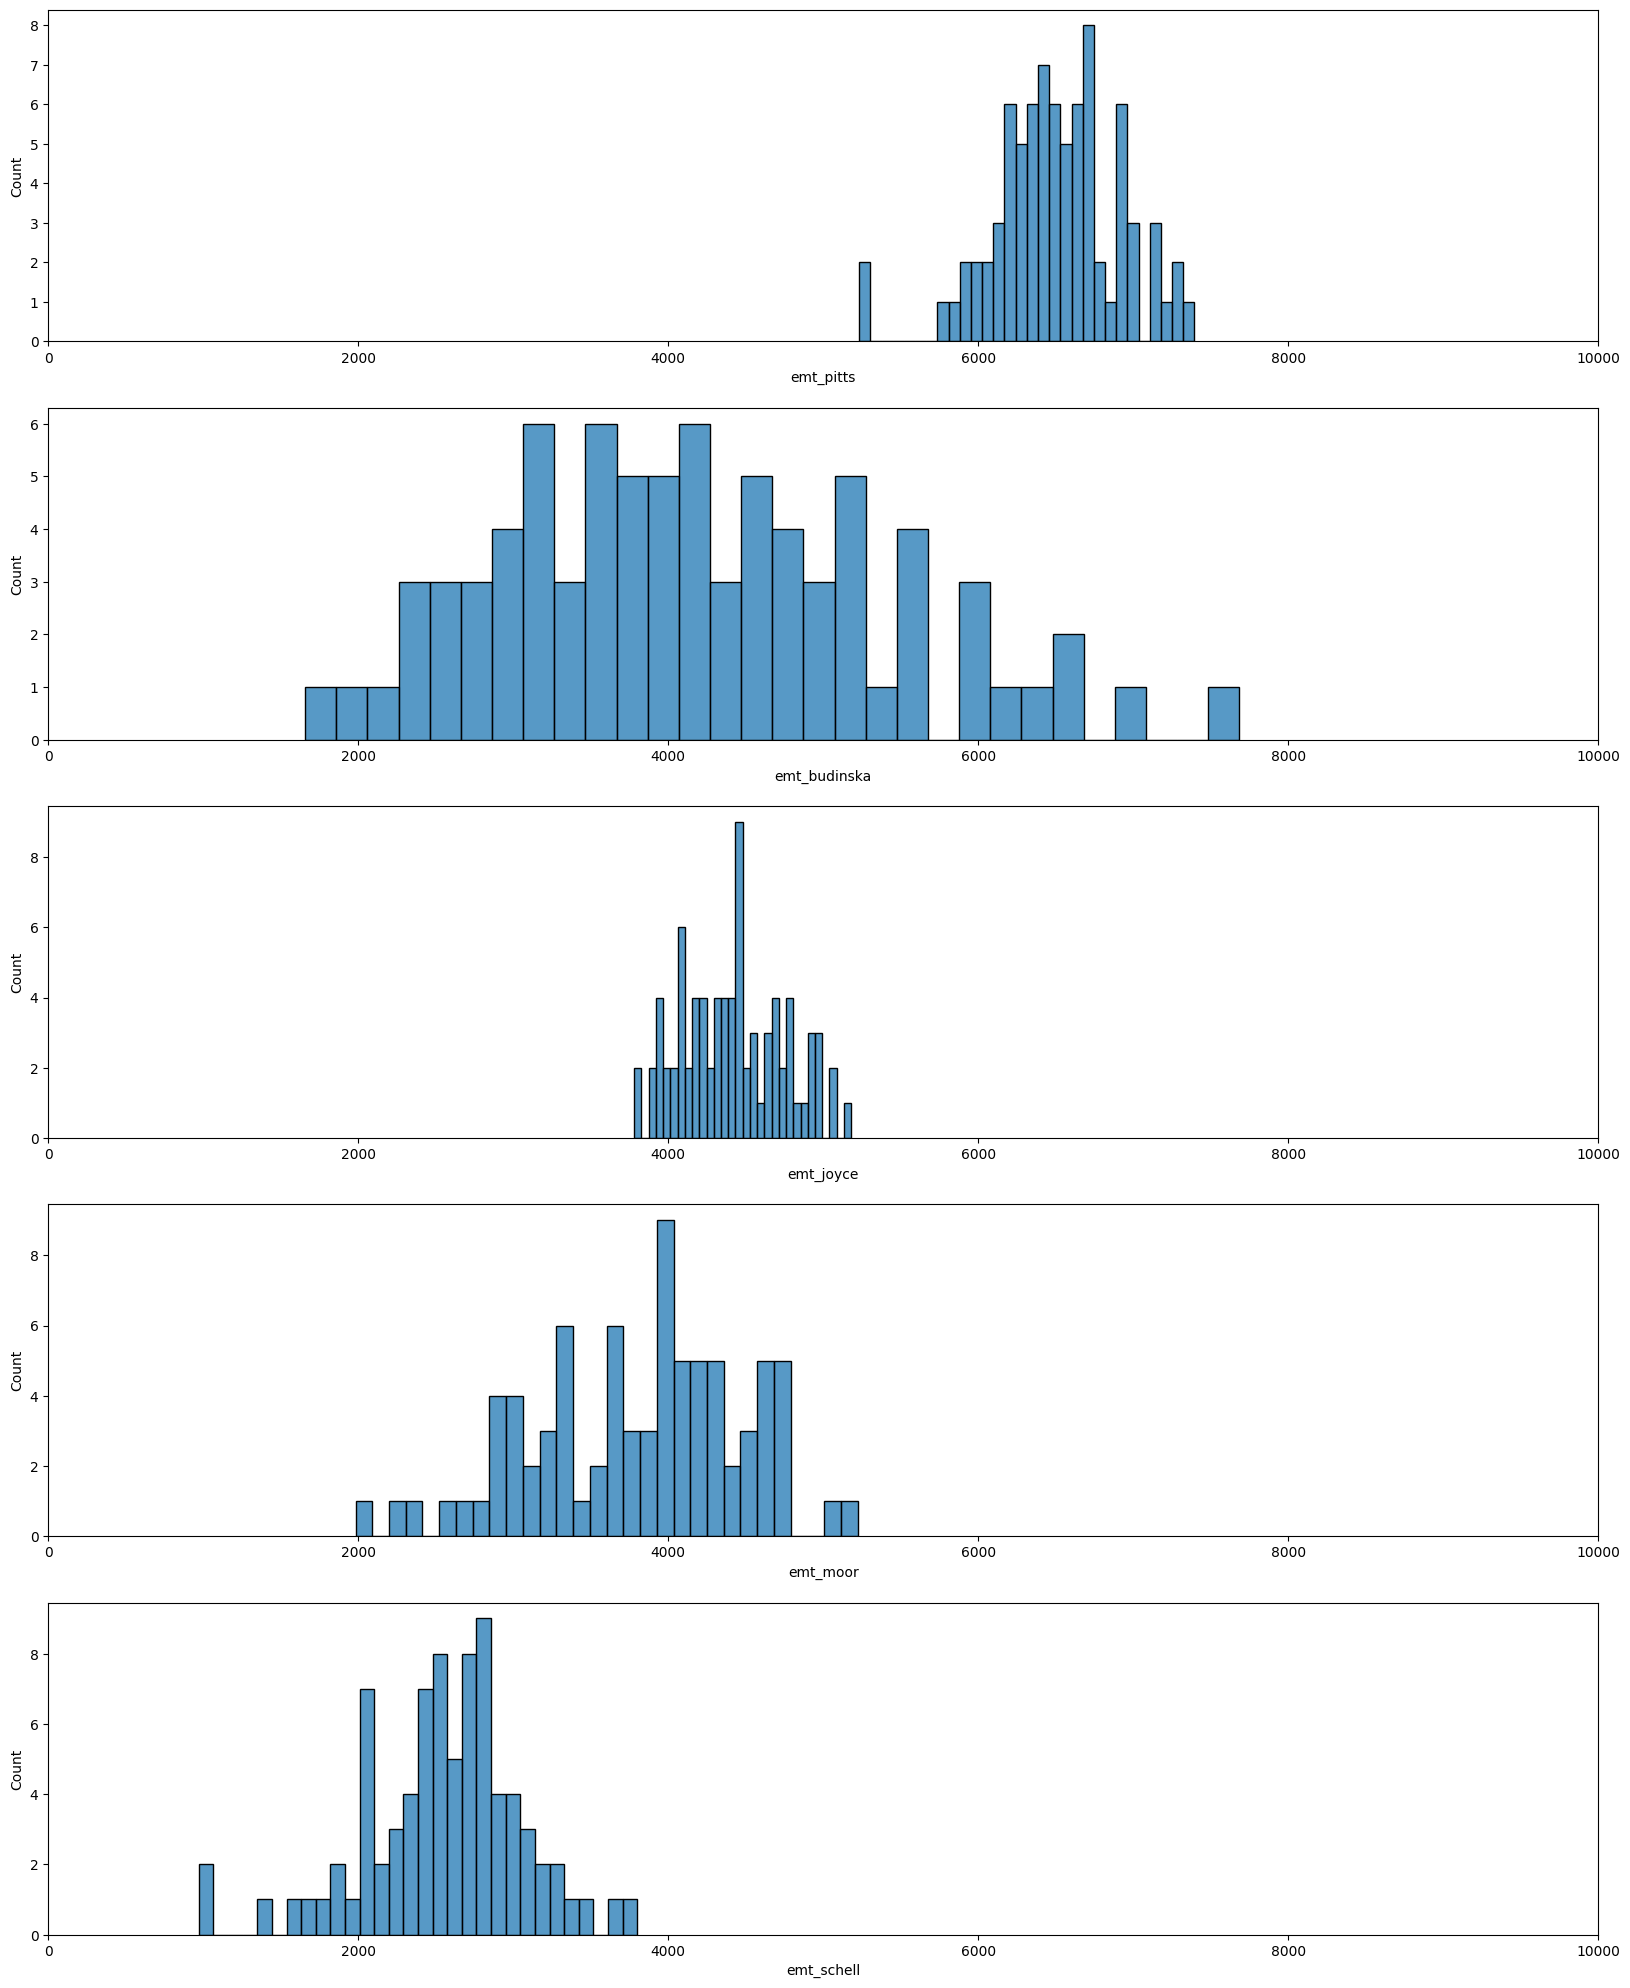

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(20, 25))
for i, signature in enumerate(emt_gene_lists):
    sns.histplot(log_tpms_with_emt_signatures[signature], bins=30, ax=axs[i])
    axs[i].set_xlim(0, 10_000)
    # sns.kdeplot(log_tpms_with_emt_signatures[signature] * 2, ax=axs[i])

In [11]:
for i, signature in enumerate(emt_gene_lists):
    log_tpms_with_emt_signatures[signature + '_rank'] = log_tpms_with_emt_signatures[signature].rank(ascending=False)

log_tpms_with_emt_signatures = log_tpms_with_emt_signatures.set_index('sample_id')
log_tpms_with_emt_signatures

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,emt_pitts,emt_budinska,emt_joyce,emt_moor,emt_schell,emt_pitts_rank,emt_budinska_rank,emt_joyce_rank,emt_moor_rank,emt_schell_rank
sample_id,,,,,,,,,,,,,,,,,,,,,
18R177_0021,5.672374,0.000000,7.893859,3.436497,4.016985,1.061024,5.464971,5.005462,6.616661,4.511973,...,5866.953843,2384.899609,4012.613275,3077.784986,2498.450689,78.0,77.0,72.0,67.0,48.0
18R178_0022,5.674291,0.360345,8.864981,3.459952,5.127833,1.333578,5.479336,5.518125,6.684637,4.339141,...,6594.988994,3535.281233,4441.565678,4514.80957,2508.789633,35.0,55.0,38.0,14.0,44.0
18R296_0008,7.606478,0.502548,8.949938,2.945925,3.997846,2.127446,5.718449,5.033901,6.493254,4.272012,...,6688.133068,2560.345451,4066.70393,2408.561145,2107.552986,27.0,74.0,67.0,79.0,65.0
18R301_0002,6.804048,2.781194,8.366144,2.738390,4.675337,1.072083,5.625562,5.008174,6.897100,3.967913,...,6963.490954,4101.9309,4683.048238,4587.941901,2643.881037,10.0,39.0,21.0,12.0,39.0
18R421_0001,5.108591,1.154345,7.674760,3.302905,4.219908,2.369596,6.224519,5.742430,6.676583,4.355505,...,6961.328867,5110.859381,4722.042227,4102.089534,3114.868401,11.0,19.0,17.0,30.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R299_0025,5.826797,0.245345,8.543566,3.406724,4.605106,1.638539,5.373508,5.002043,6.725416,3.989550,...,6698.388759,2986.995389,4070.420327,1983.059407,2505.74306,26.0,68.0,66.0,81.0,45.0
18R300_0027,6.010276,1.360005,9.144012,2.642160,4.045131,1.411634,5.899354,4.646930,6.749096,5.013906,...,6362.429895,3682.437658,4407.384924,4139.060665,2405.685538,53.0,50.0,41.0,28.0,55.0
18R302_0004,7.224287,0.493080,9.016678,2.605669,4.270374,2.048614,6.498189,5.551379,6.817707,4.143490,...,6227.700952,4564.051229,4212.086967,3978.257456,2415.726374,65.0,28.0,55.0,36.0,53.0


In [12]:
def is_pd(s):
    return not 'non-PD' in s

def is_nonpd(s):
    return 'non-PD' in s

# ann_post_pd = ann_post.loc[ann_post['treatment response'].apply(is_pd)]
# ann_post_nonpd = ann_post.loc[ann_post['treatment response'].apply(is_nonpd)]
# 
# log_tpms_with_emt_signatures_post_pd = log_tpms_with_emt_signatures.loc[ann_post_pd['sample_id']]
# log_tpms_with_emt_signatures_post_nonpd = log_tpms_with_emt_signatures.loc[ann_post_nonpd['sample_id']]

log_tpms_with_emt_signatures_with_ann = log_tpms_with_emt_signatures.merge(ann, on='sample_id')
df_post = log_tpms_with_emt_signatures_with_ann[log_tpms_with_emt_signatures_with_ann['time point'] == 'post-treatment']
df_post

,sample_id,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,...,emt_budinska_rank,emt_joyce_rank,emt_moor_rank,emt_schell_rank,sample_title,tissue,time point,treatment response,patient_id,gsm_id
29,18R465_0006,4.563501,0.350781,7.096001,3.046083,4.362369,0.655536,9.721833,4.235843,7.423759,...,46.0,9.0,61.0,80.0,POST-R-016,primary tumor (colorectum),post-treatment,post-tx PD,16,GSM5575440
49,18R648_0009,5.969269,0.000000,7.602101,2.741572,4.594683,4.652596,7.004454,4.160114,6.999241,...,29.0,51.0,59.0,32.0,PAIR-R-008,primary tumor (colorectum),post-treatment,post-Tx non-PD,8,GSM5575360
50,18R649_0010,5.039371,0.686348,6.723200,3.303250,4.287397,1.882578,7.496040,4.775423,6.885067,...,12.0,28.0,68.0,7.0,POST-R-001,primary tumor (colorectum),post-treatment,post-Tx non-PD,1,GSM5575333
51,18R653_0014,5.105479,0.848884,7.692091,2.782425,4.598641,2.033024,7.954040,4.400878,7.206700,...,7.0,45.0,75.0,21.0,POST-R-013,primary tumor (colorectum),post-treatment,post-tx PD,13,GSM5575390
54,18R657_0019,7.292755,1.595991,8.881226,2.768909,4.356199,0.871336,6.486989,5.541568,7.430392,...,70.0,59.0,71.0,72.0,PAIR-R-021,primary tumor (colorectum),post-treatment,post-tx PD,21,GSM5575438
55,18R659_0020,4.845807,0.466244,7.380893,2.888520,4.518241,2.924910,7.759256,4.279332,7.055717,...,17.0,40.0,76.0,58.0,POST-R-010,primary tumor (colorectum),post-treatment,post-Tx non-PD,10,GSM5575375
56,18R661_0021,6.784020,0.344468,8.655422,3.318332,5.248280,1.211245,5.386235,4.771068,7.592629,...,73.0,69.0,60.0,76.0,POST-R-011,primary tumor (colorectum),post-treatment,post-Tx non-PD,11,GSM5575376
57,18R663_0027,5.831205,0.074278,7.800333,3.038935,4.940699,1.442684,5.732188,4.662695,7.210671,...,56.0,58.0,41.0,73.0,POST-R-012,primary tumor (colorectum),post-treatment,post-Tx non-PD,12,GSM5575380
59,18R669_0001,6.211618,1.144533,7.985421,2.862102,4.880692,1.185978,5.859502,5.254498,6.929693,...,45.0,62.0,18.0,19.0,POST-R-002,primary tumor (colorectum),post-treatment,post-Tx non-PD,2,GSM5575336
61,18R673_0005,6.741367,0.162434,8.622434,2.299271,4.733076,2.000623,4.839310,5.446819,7.651958,...,75.0,75.0,32.0,50.0,POST-R-015,primary tumor (colorectum),post-treatment,post-Tx non-PD,15,GSM5575439


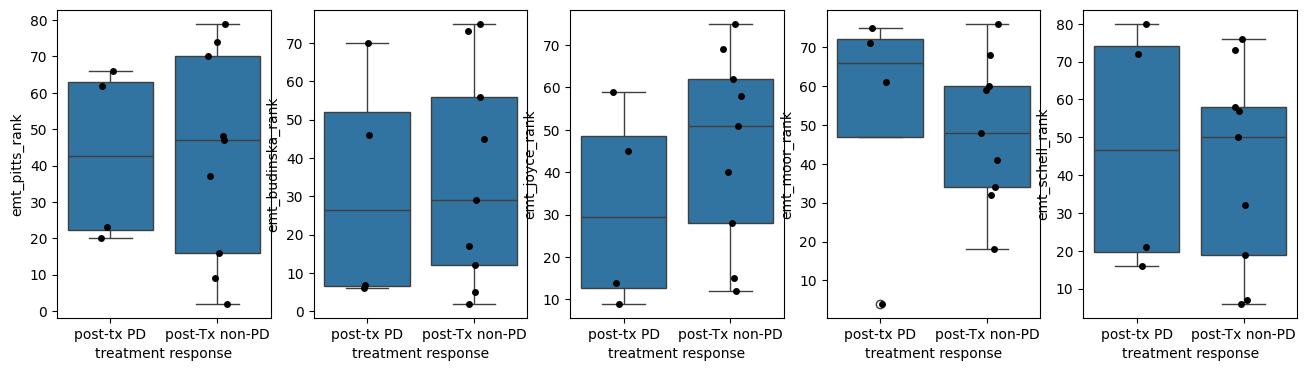

In [13]:
fig, axs = plt.subplots(1, len(emt_gene_lists), figsize=(16, 4))

for signature, ax in zip(emt_gene_lists, axs):
    sns.boxplot(df_post, x='treatment response', y=f'{signature}_rank', ax=ax)
    sns.stripplot(x='treatment response', y=f'{signature}_rank', data=df_post, color='black', jitter=True, dodge=True, ax=ax)

In [14]:
df_pre = log_tpms_with_emt_signatures_with_ann[log_tpms_with_emt_signatures_with_ann['time point'] == 'pre-treatment']
joined = df_pre.merge(df_post, on='patient_id', how='inner')[['sample_id_x', 'treatment response_y']]
joined = joined.rename(columns={'sample_id_x': 'sample_id', 'treatment response_y': 'treatment response'})
df_pre_with_response = df_pre.merge(joined, on='sample_id', how='inner')
df_pre_with_response.head()

,sample_id,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,...,emt_joyce_rank,emt_moor_rank,emt_schell_rank,sample_title,tissue,time point,treatment response_x,patient_id,gsm_id,treatment response_y
0,18R178_0022,5.674291,0.360345,8.864981,3.459952,5.127833,1.333578,5.479336,5.518125,6.684637,...,38.0,14.0,44.0,PRE-R-006,primary tumor (colorectum),pre-treatment,pre-Tx,6,GSM5575369,post-tx PD
1,18R301_0002,6.804048,2.781194,8.366144,2.738390,4.675337,1.072083,5.625562,5.008174,6.897100,...,21.0,12.0,39.0,PRE-R-008,primary tumor (colorectum),pre-treatment,pre-Tx,8,GSM5575377,post-Tx non-PD
2,18R429_0009,5.984682,0.929431,7.695093,2.937784,4.425176,1.513704,6.800162,5.269630,7.005123,...,19.0,20.0,10.0,PRE-R-002,primary tumor (colorectum),pre-treatment,pre-Tx,2,GSM5575351,post-Tx non-PD
3,18R432_0012,6.822792,0.543080,9.593224,3.046578,5.256667,2.100133,5.277666,5.640768,7.574788,...,64.0,43.0,77.0,PRE-R-012,primary tumor (colorectum),pre-treatment,pre-Tx,12,GSM5575391,post-Tx non-PD
4,18R443_0022,6.765031,1.630076,9.010288,2.784874,5.240803,1.450181,5.586477,5.671572,7.893456,...,39.0,16.0,47.0,PRE-R-015,primary tumor (colorectum),pre-treatment,pre-Tx,15,GSM5575398,post-Tx non-PD


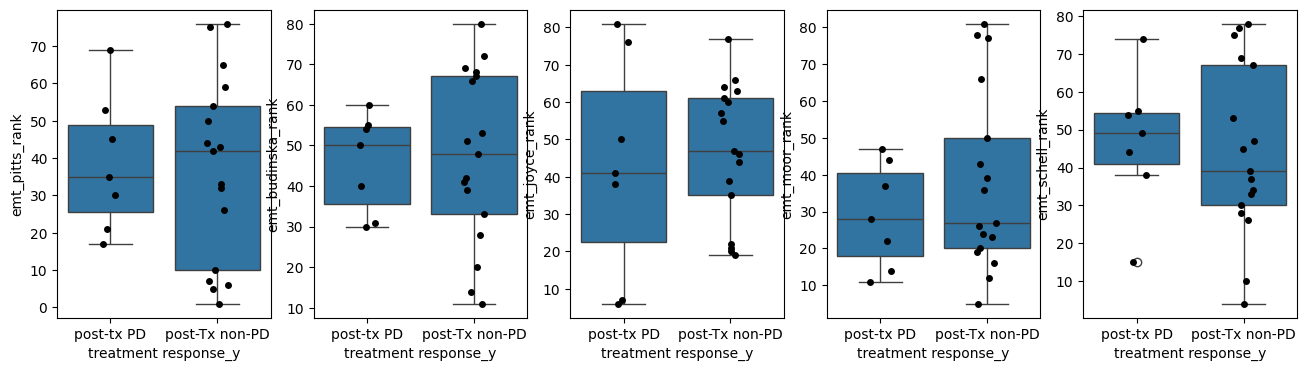

In [15]:
fig, axs = plt.subplots(1, len(emt_gene_lists), figsize=(16, 4))

for signature, ax in zip(emt_gene_lists, axs):
    sns.boxplot(df_pre_with_response, x='treatment response_y', y=f'{signature}_rank', ax=ax)
    sns.stripplot(x='treatment response_y', y=f'{signature}_rank', data=df_pre_with_response, color='black', jitter=True, dodge=True, ax=ax)

MET genes in total:  5
MET genes in our data:  5
Negative genes:  
Positive genes:  emt_budinska_rank
MET genes in total:  5
MET genes in our data:  5
Negative genes:  
Positive genes:  


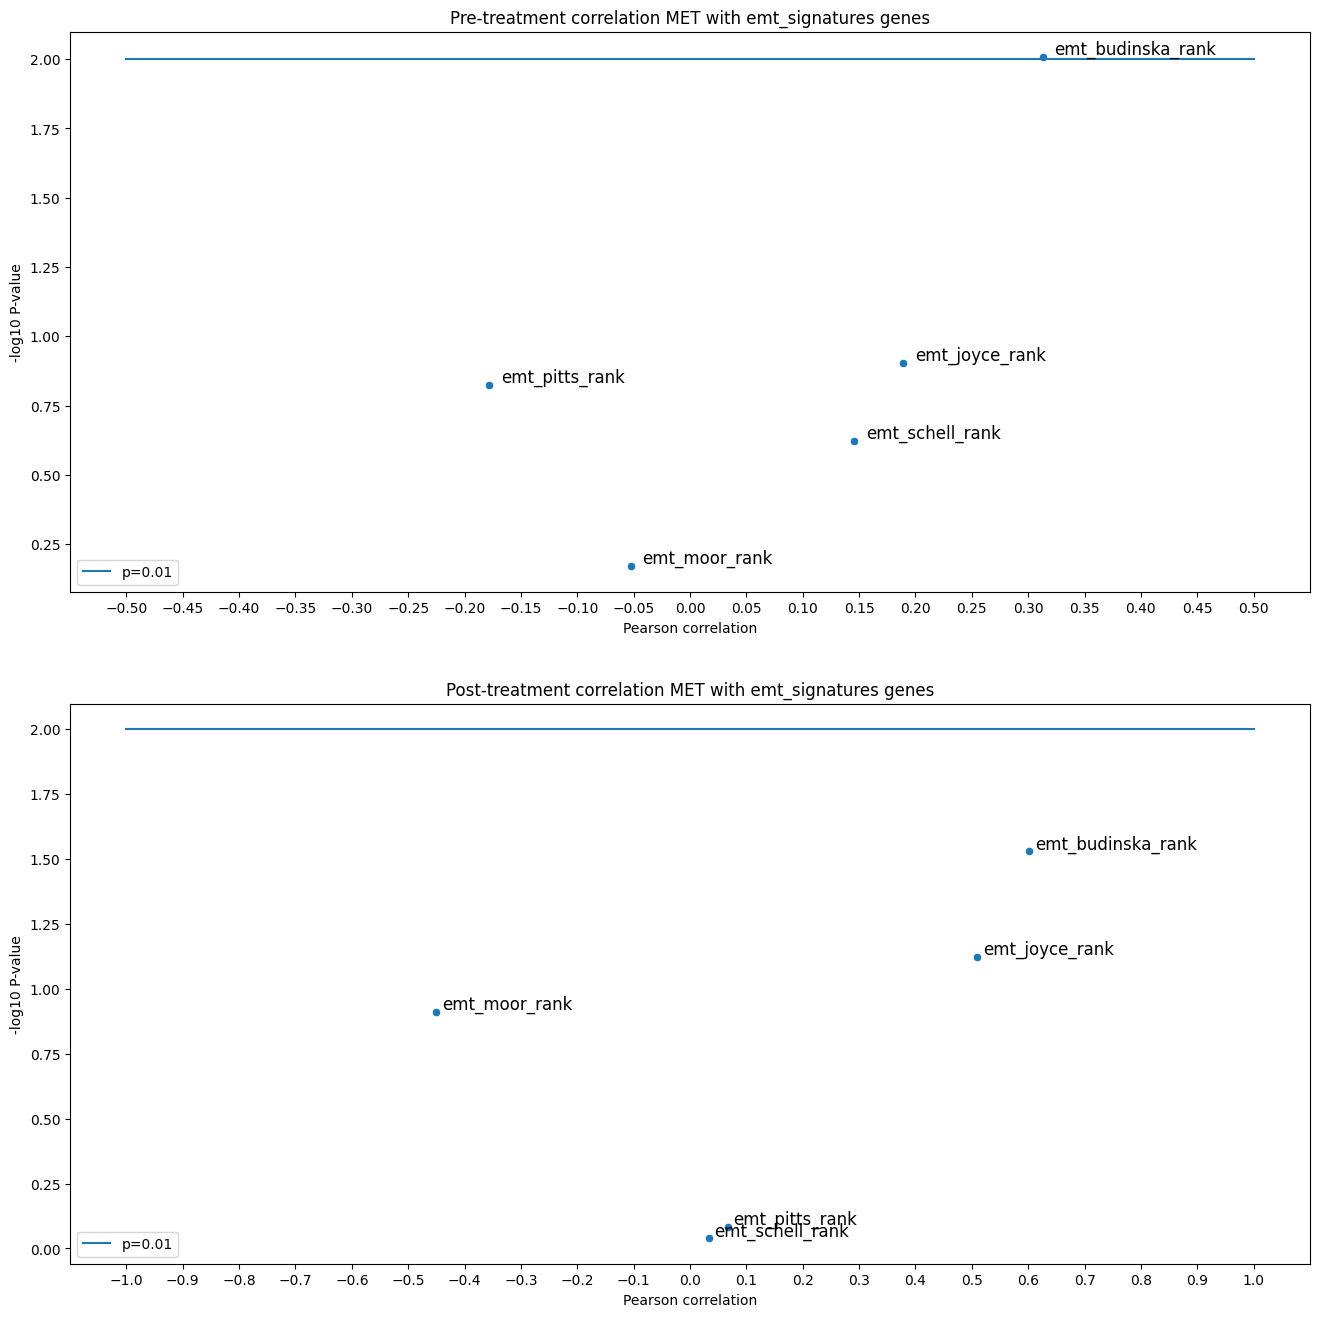

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

signatures_file = open('data/gene_lists/emt_signatures.txt', 'w').write('emt_pitts_rank, emt_budinska_rank, emt_joyce_rank, emt_moor_rank, emt_schell_rank')

for i, filename in enumerate(['emt_signatures']):
    plot_correlations(df_pre, f'Pre-treatment correlation MET with {filename} genes',
                      'MET', f'data/gene_lists/{filename}.txt',
                      xlim=(-0.5, 0.5), ax=axs[i * 2])
    plot_correlations(df_post, f'Post-treatment correlation MET with {filename} genes', 
                      'MET', f'data/gene_lists/{filename}.txt',
                      xlim=(-1, 1), ax=axs[i * 2 + 1])